# Titanic survival prediction

URL: https://www.kaggle.com/competitions/titanic/overview

**Data Dictionary**<br>
survival:	Survival	0 = No, 1 = Yes<br>
pclass:	Ticket class	1 = 1st, 2 = 2nd, 3 = 3rd<br>
sex:	Sex	
Age:	Age in years	
sibsp:	# of siblings / spouses aboard the Titanic	
parch:	# of parents / children aboard the Titanic	
ticket:	Ticket number	
fare:	Passenger fare	
cabin:	Cabin number	
embarked:	Port of Embarkation	C = Cherbourg, Q = Queenstown, S = Southampton


**Variable Notes**<br>
pclass: A proxy for socio-economic status (SES). 1st = Upper, 2nd = Middle, 3rd = Lower<br><br>
age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5<br><br>
sibsp: The dataset defines family relations in this way...<br>
    Sibling = brother, sister, stepbrother, stepsister<br>
    Spouse = husband, wife (mistresses and fiancés were ignored)<br><br>
parch: The dataset defines family relations in this way...<br>
    Parent = mother, father<br>
    Child = daughter, son, stepdaughter, stepson<br>
    Some children travelled only with a nanny, therefore parch=0 for them.

## Importing packages

In [1]:
# pip install -q tensorflow_decision_forests

In [1]:
# Dataframe related operations
import pandas as pd
import numpy as np

import os

# Categorical data pre-processing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# Standardize numeric columns
from sklearn.preprocessing import StandardScaler

# Graphs
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow related packages
import tensorflow as tf
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam

# import tensorflow_decision_forests as tfdf


# Evaluation
from sklearn.metrics import classification_report, accuracy_score

In [2]:
import tensorflow_decision_forests as tfdf

## Loading data

In [3]:
train_raw = pd.read_csv(os.path.join('titanic_data', 'train.csv'))
test_raw = pd.read_csv(os.path.join('titanic_data', 'test.csv'))

In [4]:
train_raw.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Training data Pre-processing

### Data Imputation

Based on the learnings from EDA on this dataset, below are some preprocessing we will perform on the dataset before building a model:
1. Some records have Age missing. We will impute the Age column in those records with the mean value of that gender.
2. There are some records with Embarkment port missing, we will impute the Embarked column in those records with the most occuring port in the dataset.
3. To extract some information out of Ticket column we will create a column that shows number of passengers per ticket i.e number of people who travelled together on each ticket. We will also check the correlation of this with other numerical variables and maybe not include it in the final training dataset if it is highly correlated with other variables like SibSp and Parch.

In [5]:
train_age_mean = train_raw.groupby('Sex')['Age'].transform('mean')
train_embarked_mode = train_raw.Embarked.mode()[0]

In [6]:
train_raw['Age'] = train_raw['Age'].fillna(train_age_mean)
train_raw['Embarked'] = train_raw['Embarked'].fillna(train_embarked_mode)
# Calculate the number of people on each ticket
train_raw['Num_Passengers_Per_Ticket'] = train_raw.groupby('Ticket')['Ticket'].transform('count')

In [7]:
train_raw[['Age', 'Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Num_Passengers_Per_Ticket']].corr()

,Age,Survived,Pclass,Age,SibSp,Parch,Fare,Num_Passengers_Per_Ticket
Age,1.000000,-0.080453,-0.330391,1.000000,-0.236920,-0.182556,0.089079,-0.223930
Survived,-0.080453,1.000000,-0.338481,-0.080453,-0.035322,0.081629,0.257307,0.038247
Pclass,-0.330391,-0.338481,1.000000,-0.330391,0.083081,0.018443,-0.549500,-0.002633
Age,1.000000,-0.080453,-0.330391,1.000000,-0.236920,-0.182556,0.089079,-0.223930
SibSp,-0.236920,-0.035322,0.083081,-0.236920,1.000000,0.414838,0.159651,0.661622
Parch,-0.182556,0.081629,0.018443,-0.182556,0.414838,1.000000,0.216225,0.593076
Fare,0.089079,0.257307,-0.549500,0.089079,0.159651,0.216225,1.000000,0.345541
Num_Passengers_Per_Ticket,-0.223930,0.038247,-0.002633,-0.223930,0.661622,0.593076,0.345541,1.000000


In [8]:
# Pre-processing for Test data
test_raw['Age'] = test_raw['Age'].fillna(train_age_mean)
test_raw['Embarked'] = test_raw['Embarked'].fillna(train_embarked_mode)
# Calculate the number of people on each ticket
test_raw['Num_Passengers_Per_Ticket'] = test_raw.groupby('Ticket')['Ticket'].transform('count')

### Standardization & categorical data processing

1. Fare: This column has outliers but we will keep them to understand if a higher fare affects the chances of survival. We will however, standardize the values
2. Age: Standardization needed.
3. One-hot encoding for Sex and Embarked.

In [9]:
# STANDARDIZATION
# Create a StandardScaler object
scaler = StandardScaler()

# Fit and transform the 'Age' and 'Fare' columns
train_raw[['Age', 'Fare']] = scaler.fit_transform(train_raw[['Age', 'Fare']])

# Transform the 'Age' and 'Fare' columns in the test data using the same scaler
test_raw[['Age', 'Fare']] = scaler.transform(test_raw[['Age', 'Fare']])

In [10]:
# ONE-HOT ENCODING
# This function takes care of OneHotEncoding the categorical columns and creates an easy to understand output
def category_to_column(df, column, prefix='', dummy_variable_list=[]):
    df_copy = df.copy()
    oe_style = OneHotEncoder()
    oe_results = oe_style.fit_transform(df_copy[[column]])
    name_columns = [prefix  + str(cat) for cat in oe_style.categories_[0]]
    temp = pd.DataFrame(oe_results.toarray(), columns=name_columns, index=df_copy.index)
    df_copy = pd.concat([df_copy, temp], axis=1)
    return df_copy

# All categorical columns
columns_category = ['Sex', 'Embarked']
# List dummy variables from each category that can be dropped
dummy_variable_list = []

# OneHoteEncoding each categorical column one by one
for column in columns_category:
    train_raw = category_to_column(train_raw, column, column, dummy_variable_list)
    test_raw = category_to_column(test_raw, column, column, dummy_variable_list)
    dummy_variable_list.append(train_raw.columns[-1])

## Creating Train & Test dataset

### Drop excluded columns and convert datatype

In [11]:
train_final = train_raw.copy()
test_final = test_raw.copy()

# Excluded columns list
drop_col = ['PassengerId', 'Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
all_drop_cols = drop_col + dummy_variable_list
# Final train and test structure
train_final = train_final.drop(columns=all_drop_cols)
test_final = test_final.drop(columns=all_drop_cols)

# Convert to float
train_final = train_final.astype(float)
test_final = test_final.astype(float)

In [12]:
X_train = train_final.drop(columns=['Survived']).copy()
y_train = train_final['Survived']

X_test = test_final.copy()

### Converting to right datatype

In [13]:
X_train = X_train.astype(float)
y_train = y_train.astype(float)

X_test = X_test.astype(float)

In [14]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Pclass                     418 non-null    float64
 1   Age                        418 non-null    float64
 2   SibSp                      418 non-null    float64
 3   Parch                      418 non-null    float64
 4   Fare                       417 non-null    float64
 5   Num_Passengers_Per_Ticket  418 non-null    float64
 6   Sexfemale                  418 non-null    float64
 7   EmbarkedC                  418 non-null    float64
 8   EmbarkedQ                  418 non-null    float64
dtypes: float64(9)
memory usage: 29.5 KB


## Training a model

In [16]:
# Set the seed for reproducibility
tf.random.set_seed(42)

def get_model():
    # Define the input layer with a shape of (100,)
    input_layer = Input(shape=(X_train.shape[1],))

    # Add the first dense layer with 128 units and 'relu' activation
    x = Dense(128, activation='relu')(input_layer)

    # Add the second dense layer with 64 units and 'relu' activation
    x = Dense(64, activation='relu')(x)

    # Add the third dense layer with 32 units and 'relu' activation
    x = Dense(32, activation='relu')(x)

    # Add the output layer with 1 unit and 'sigmoid' activation
    output_layer = Dense(1, activation='sigmoid')(x)

    # Create a model with the input and output layers
    model = Model(inputs=input_layer, outputs=output_layer)

    # Compile the model with binary cross-entropy loss, Adam optimizer with a learning rate of 0.0001, and accuracy metric
    model.compile(loss='binary_crossentropy',
          optimizer= Adam(learning_rate=0.0001),
          metrics=['accuracy'])

    return model

model = get_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 9)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,649 (45.50 KB)

 Trainable params: 11,649 (45.50 KB)

 Non-trainable params: 0 (0.00 B)

### 

In [17]:
# Plotting the loss and accuracy curves
def plot_accuracy_and_loss(tf_trained_model):
    # Plot accuracy
    plt.plot(tf_trained_model.history['accuracy'])
    plt.plot(tf_trained_model.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)  # Add gridlines
    plt.show()

    # Plot loss
    plt.plot(tf_trained_model.history['loss'])
    plt.plot(tf_trained_model.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.grid(True)  # Add gridlines
    plt.show()

In [18]:
## training the model
training_model = model.fit(X_train,y_train,\
                    batch_size=200,# Size of each batch
                    epochs=150, # Number of iterations for training on each batch
                    validation_split= 0.2, # Validation split
                    shuffle = True, # Randomizing the order of the samples before each epoch
                    verbose=1)

Epoch 1/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.5695 - loss: 0.6915 - val_accuracy: 0.6257 - val_loss: 0.6848
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5980 - loss: 0.6827 - val_accuracy: 0.6480 - val_loss: 0.6742
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6097 - loss: 0.6736 - val_accuracy: 0.6536 - val_loss: 0.6637
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6204 - loss: 0.6648 - val_accuracy: 0.6592 - val_loss: 0.6535
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6195 - loss: 0.6565 - val_accuracy: 0.6536 - val_loss: 0.6437
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6252 - loss: 0.6487 - val_accuracy: 0.6480 - val_loss: 0.6345
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6260 - loss: 0.6417 - val_accuracy: 0.6480 - val_loss: 0.6262
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6288 - loss: 0.6353 - val_accuracy: 0.6480 - val_loss: 0.6186

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8178 - loss: 0.4328 - val_accuracy: 0.8492 - val_loss: 0.3856
Epoch 104/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8178 - loss: 0.4322 - val_accuracy: 0.8492 - val_loss: 0.3850
Epoch 105/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8178 - loss: 0.4317 - val_accuracy: 0.8492 - val_loss: 0.3843
Epoch 106/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8178 - loss: 0.4312 - val_accuracy: 0.8492 - val_loss: 0.3837
Epoch 107/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8178 - loss: 0.4306 - val_accuracy: 0.8492 - val_loss: 0.3831
Epoch 108/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8178 - loss: 0.4301 - val_accuracy: 0.8492 - val_loss: 0.3825
Epoch 109/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8178 - loss: 0.4296 - val_accuracy: 0.8492 - val_loss: 0.3819
Epoch 110/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8154 - loss: 0.4291 - val_accuracy: 0.8547 - val_loss: 0.381

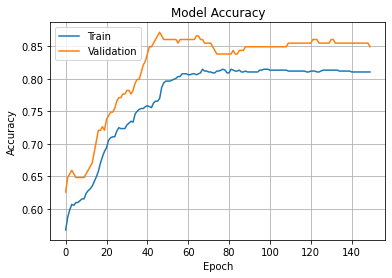

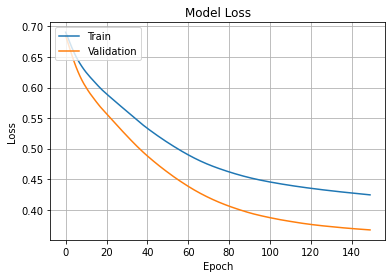

In [19]:
plot_accuracy_and_loss(training_model)

#### Trying epoch = 70 to utilize above model's output

In the two graphs above, we see accuracy peacking around 70 and loss dropping after 80. So I chose 70 as a epoch selection

In [20]:
model = get_model()

## training the model
training_model2 = model.fit(X_train,y_train,\
                    batch_size=200,# Size of each batch
                    epochs=70, # Number of iterations for training on each batch
                    validation_split= 0.2, # Validation split
                    shuffle = True, # Randomizing the order of the samples before each epoch
                    verbose=1)

Epoch 1/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6514 - loss: 0.6790 - val_accuracy: 0.6760 - val_loss: 0.6745
Epoch 2/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6323 - loss: 0.6680 - val_accuracy: 0.6760 - val_loss: 0.6628
Epoch 3/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6518 - loss: 0.6584 - val_accuracy: 0.6480 - val_loss: 0.6521
Epoch 4/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6457 - loss: 0.6497 - val_accuracy: 0.6592 - val_loss: 0.6424
Epoch 5/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6498 - loss: 0.6420 - val_accuracy: 0.6648 - val_loss: 0.6338
Epoch 6/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6519 - loss: 0.6353 - val_accuracy: 0.6648 - val_loss: 0.6262
Epoch 7/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6572 - loss: 0.6293 - val_accuracy: 0.6592 - val_loss: 0.6191
Epoch 8/70
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6572 - loss: 0.6239 - val_accuracy: 0.6648 - val_loss: 0.6126
Epoch 9

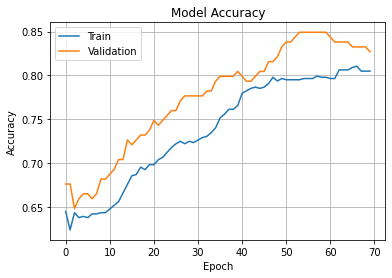

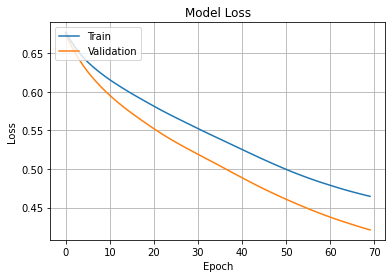

In [21]:
plot_accuracy_and_loss(training_model2)

In [22]:
y_pred =  model.predict(X_test)
threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


In [23]:
test_with_predictions = test_raw.copy()
test_with_predictions['Survived'] = y_pred
test_with_predictions[['PassengerId', 'Survived']]\
    .to_csv('Submissions/submission.csv', index=False)

#### Trying dropout in Sequential model

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dropout(0.2, input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## training the model
training_model_dropout = model.fit(X_train,y_train,\
                    batch_size=200,# Size of each batch
                    epochs=150, # Number of iterations for training on each batch
                    validation_split= 0.2, # Validation split
                    shuffle = True, # Randomizing the order of the samples before each epoch
                    verbose=1)

Epoch 1/150


/Users/shipsinh/opt/anaconda3/lib/python3.9/site-packages/keras/src/layers/regularization/dropout.py:42: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.5171 - loss: 0.7016 - val_accuracy: 0.6927 - val_loss: 0.6299
Epoch 2/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6620 - loss: 0.6446 - val_accuracy: 0.6816 - val_loss: 0.5916
Epoch 3/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6735 - loss: 0.6158 - val_accuracy: 0.7263 - val_loss: 0.5636
Epoch 4/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6791 - loss: 0.6051 - val_accuracy: 0.7542 - val_loss: 0.5467
Epoch 5/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7274 - loss: 0.5847 - val_accuracy: 0.7877 - val_loss: 0.5334
Epoch 6/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.7341 - loss: 0.5718 - val_accuracy: 0.7933 - val_loss: 0.5189
Epoch 7/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7253 - loss: 0.5803 - val_accuracy: 0.8101 - val_loss: 0.5035
Epoch 8/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7241 - loss: 0.5572 - val_accuracy: 0.8156 - val_loss: 0.4911
Epoch 9/1

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7989 - loss: 0.4596 - val_accuracy: 0.8436 - val_loss: 0.3980
Epoch 104/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8022 - loss: 0.4654 - val_accuracy: 0.8547 - val_loss: 0.3907
Epoch 105/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8016 - loss: 0.4321 - val_accuracy: 0.8547 - val_loss: 0.3854
Epoch 106/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.7967 - loss: 0.4620 - val_accuracy: 0.8547 - val_loss: 0.3852
Epoch 107/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7951 - loss: 0.4740 - val_accuracy: 0.8492 - val_loss: 0.3888
Epoch 108/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7953 - loss: 0.4575 - val_accuracy: 0.8324 - val_loss: 0.3960
Epoch 109/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7878 - loss: 0.4722 - val_accuracy: 0.8436 - val_loss: 0.3948
Epoch 110/150
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7683 - loss: 0.4958 - val_accuracy: 0.8492 - val_loss: 0.392

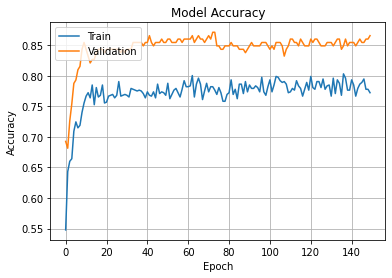

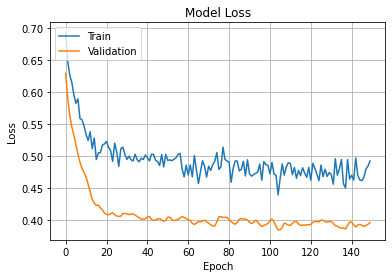

In [25]:
plot_accuracy_and_loss(training_model_dropout)

Didn't really achieve much with this.

#### Trying Decision Trees

In [15]:
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0, # Very few logs
    features=[tfdf.keras.FeatureUsage(name=n) for n in X_train.columns],
    exclude_non_specified_features=True, # Only use the features in "features"
    random_seed=1234,
)


training_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_final, label="Survived")

# Compile the model
model.compile(
    optimizer="adam",  # Specify the optimizer
    loss="binary_crossentropy",  # Specify the loss function for classification
    metrics=["accuracy"]
)

# Train the model
training_model_gradient = model.fit(training_tf_dataset,\
                    verbose=1)
# model.fit(training_tf_dataset)


self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

Reading training dataset...
Training dataset read in 0:00:03.883966. Found 891 examples.
Training model...
Model trained in 0:00:00.162301
Compiling model...
Model compiled.
Accuracy: 0.8152173757553101 Loss:0.9192756414413452


#### Decision Tree with some hyper-parameters

In [16]:
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0, # Very few logs
    features=[tfdf.keras.FeatureUsage(name=n) for n in X_train.columns],
    exclude_non_specified_features=True, # Only use the features in "features"
        
    # Only for GBT.
    # A bit slower, but great to understand the model.
    # compute_permutation_variable_importance=True,
    
    # Change the default hyper-parameters
    # hyperparameter_template="benchmark_rank1@v1",
    
    #num_trees=1000,
    #tuner=tuner
    
    min_examples=1,
    categorical_algorithm="RANDOM",
    #max_depth=4,
    shrinkage=0.05,
    #num_candidate_attributes_ratio=0.2,
    split_axis="SPARSE_OBLIQUE",
    sparse_oblique_normalization="MIN_MAX",
    sparse_oblique_num_projections_exponent=2.0,
    num_trees=2000,
    #validation_ratio=0.0,
    random_seed=1234,
    
)

training_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_final, label="Survived")
model.fit(training_tf_dataset)

self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

Accuracy: 0.760869562625885 Loss:0.9827604293823242


In [17]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (9):
	Age
	EmbarkedC
	EmbarkedQ
	Fare
	Num_Passengers_Per_Ticket
	Parch
	Pclass
	Sexfemale
	SibSp

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.                       "Age"  0.500305 ################
    2. "Num_Passengers_Per_Ticket"  0.253401 ###
    3.                      "Fare"  0.246858 ###
    4.                 "EmbarkedQ"  0.221476 ##
    5.                 "EmbarkedC"  0.218567 ##
    6.                    "Pclass"  0.181748 
    7.                     "Parch"  0.177031 
    8.                 "Sexfemale"  0.176002 
    9.                     "SibSp" 

#### Training a Decision Tree model with hyperparameter tuning

The goal is to train a Decision Tree model with some hyperparameter tuning. Below are some details on some hyperparameters that been used in the following code.

Q. What is split_axis parameter in tfdf? <br>

- Split axis refers to the axis or direction along which a feature's values are split to form branches in the decision tree. The choice of split axis can have a significant impact on the structure of the decision tree and ultimately on the model's performance.<br><br>

Q. What are some different types of split axes that can be used in decision trees?<br>

1. Axis-Aligned Split Axis: This is the most common type of split axis. It divides the feature space along one of the coordinate axes (e.g., X-axis, Y-axis, or Z-axis in a 3D space). Axis-aligned splits are simple and efficient but may not capture complex relationships in the data if the decision boundaries are not aligned with the coordinate axes.<br>
2. Sparse Oblique Split Axis: Unlike axis-aligned splits, sparse oblique splits allow the decision boundaries to be oriented arbitrarily in the feature space. This flexibility enables the model to capture more complex relationships between features, leading to potentially more accurate predictions. Sparse oblique splits are particularly useful when the relationships between features are nonlinear or when there are interactions between features. <br><br>


Q. What is sparse_oblique_normalization parameter?<br>
- The sparse_oblique_normalization parameter determines how the features are normalized before performing sparse oblique splits. Normalization is the process of scaling the values of features to a standard range or distribution. Different normalization methods can affect how the decision boundaries are formed and the overall performance of the model.

Here are the options for sparse_oblique_normalization and their meanings:

"NONE": No normalization is applied to the features before performing sparse oblique splits. This means the features are used as-is without any scaling.

"STANDARD_DEVIATION": Normalizes the features by subtracting the mean and dividing by the standard deviation. This method standardizes the features to have a mean of 0 and a standard deviation of 1.

"MIN_MAX": Normalizes the features to a specified range, typically between 0 and 1. This method scales the features proportionally to fit within the specified range.

Q. What does 'sparse_oblique_weights' do?<br>
- Sparse oblique splits are a type of split axis used in decision trees where the decision boundary is not necessarily aligned with the axes of the input features. Instead, the decision boundary can have an arbitrary orientation in the feature space. This allows for more flexible and complex decision boundaries compared to axis-aligned splits.

When using sparse oblique splits, the features are typically transformed into a higher-dimensional space where the decision boundary can be represented as a hyperplane. The weights assigned to the features in this higher-dimensional space determine the orientation and position of the decision boundary.

The sparse_oblique_weights parameter specifies how these weights should be treated. Here are the common options:

BINARY: Assigns binary weights to the features, where each feature is either included or excluded from the calculation of the decision boundary. This can result in a more sparse and interpretable decision boundary.

CONTINUOUS: Assigns continuous weights to the features, allowing for a more fine-grained control over the orientation and position of the decision boundary. This can lead to a more flexible and complex decision boundary, but it may also be harder to interpret.

Q. What does 'sparse_oblique_num_projections_exponent' do?<br>
- In oblique decision trees, a split is made using a hyperplane defined by a set of projection vectors. These projection vectors determine the direction of the hyperplane in the feature space. Sparse oblique splits, on the other hand, use a subset of the available projection vectors, making the split sparser and potentially more interpretable.

The sparse_oblique_num_projections_exponent hyperparameter represents an exponent that determines the number of projection vectors used in the sparse oblique splits. The actual number of projection vectors is calculated as 2^exponent.

Q. Is the tuned_model the best model after tuning?
- The "tuned_model" represents the model that performed the best among the set of trials conducted during the tuning process. However, it's important to note that this model may not necessarily be the absolute best model possible. There could be other combinations of hyperparameters that were not explored during the tuning process, or the performance of the model may vary depending on the dataset and task.


In [28]:
tuner = tfdf.tuner.RandomSearch(num_trials=1000) 

# Specify hyperparameter choices
tuner.choice("min_examples", [2, 5, 7, 10]) # Minimum number of examples required to create a leaf node in the decision trees
tuner.choice("categorical_algorithm", ["CART", "RANDOM"]) # Choice of algorithms for handling categorical variables in the decision trees

# Specify choices for growing strategies and related parameters
local_search_space = tuner.choice("growing_strategy", ["LOCAL"]) # "LOCAL" growing strategy grows each tree independently
local_search_space.choice("max_depth", [3, 4, 5, 6, 8]) # Maximum depth values for the decision trees when using the "LOCAL" growing strategy

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True) # growing strategy, which globally optimizes the tree structure
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256]) # Maximum number of nodes in the decision trees when using the "BEST_FIRST_GLOBAL" growing strategy

# Specify choices for gradient boosting parameters
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15]) # Choice of shrinkage values for gradient boosting
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0]) # Choice of ratio of candidate attributes to consider at each split

# Specify choices for split axis and related parameters
# "AXIS_ALIGNED": Feature values split along axes
# "SPARSE_OBLIQUE": Split made using hyperplane defined projection vectors and only subset of projection vectors used
tuner.choice("split_axis", ["AXIS_ALIGNED"]) # Feature values split along axes
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True) #
oblique_space.choice("sparse_oblique_normalization",
                     ["NONE", "STANDARD_DEVIATION", "MIN_MAX"]) # Normalization methods for sparse oblique splits
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"]) # Choice of weight types for sparse oblique split
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5]) # Number of projections exponent for sparse oblique splits

# Tune the model. Notice the `tuner=tuner`.
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
training_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_final, label="Survived")
tuned_model.fit(training_tf_dataset, verbose=1)

tuned_self_evaluation = tuned_model.make_inspector().evaluation()
print(f"Accuracy: {tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")

Use /var/folders/tm/ddg448l11_bdqk6jcwg01w540000gr/T/tmpy60li3c7 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.173289. Found 891 examples.
Training model...
Model trained in 0:03:42.015371
Compiling model...
Model compiled.
Accuracy: 0.9041095972061157 Loss:0.5275061726570129


In [46]:
tuner = tfdf.tuner.RandomSearch(num_trials=1000) 

# Specify hyperparameter choices
tuner.choice("min_examples", [2, 5, 7, 10]) # Minimum number of examples required to create a leaf node in the decision trees
tuner.choice("categorical_algorithm", ["CART", "RANDOM"]) # Choice of algorithms for handling categorical variables in the decision trees

# Specify choices for growing strategies and related parameters
local_search_space = tuner.choice("growing_strategy", ["LOCAL"]) # "LOCAL" growing strategy grows each tree independently
local_search_space.choice("max_depth", [3, 4, 5, 6, 8]) # Maximum depth values for the decision trees when using the "LOCAL" growing strategy

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True) # growing strategy, which globally optimizes the tree structure
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256]) # Maximum number of nodes in the decision trees when using the "BEST_FIRST_GLOBAL" growing strategy

# Specify choices for gradient boosting parameters
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15]) # Choice of shrinkage values for gradient boosting
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0]) # Choice of ratio of candidate attributes to consider at each split

tuner.choice("num_trees", [50, 100, 150, 200]) # Number of trees in the ensemble. Increasing this parameter can improve model performance but may also increase computation time
# tuner.choice("max_depth", [3, 4, 5, 6, 8, 10])
# tuner.choice("bagging_fraction", [0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# tuner.choice("feature_bagging_fraction", [0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
# tuner.choice("quantile_sketch_epsilon", [0.01, 0.05, 0.1, 0.2])
# tuner.choice("valid_leaf_threshold", [1.0, 2.0, 3.0, 5.0])
# tuner.choice("early_stopping_num_trees_look_ahead", [10, 20, 30, 40, 50]) # Number of trees to look ahead for early stopping. Early stopping stops training if the validation loss does not improve after a certain number of trees.


# Specify choices for split axis and related parameters
# "AXIS_ALIGNED": Feature values split along axes
# "SPARSE_OBLIQUE": Split made using hyperplane defined projection vectors and only subset of projection vectors used
tuner.choice("split_axis", ["AXIS_ALIGNED"]) # Feature values split along axes
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True) #
oblique_space.choice("sparse_oblique_normalization",
                     ["NONE", "STANDARD_DEVIATION", "MIN_MAX"]) # Normalization methods for sparse oblique splits
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"]) # Choice of weight types for sparse oblique split
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5]) # Number of projections exponent for sparse oblique splits

# Tune the model. Notice the `tuner=tuner`.
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
training_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_final, label="Survived")
tuned_model.fit(training_tf_dataset, verbose=1)

tuned_self_evaluation = tuned_model.make_inspector().evaluation()
print(f"Accuracy: {tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")

Use /var/folders/tm/ddg448l11_bdqk6jcwg01w540000gr/T/tmp1fu1y4er as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.175098. Found 891 examples.
Training model...
Model trained in 0:02:33.566439
Compiling model...
Model compiled.
Accuracy: 0.9178082346916199 Loss:0.5567752718925476


In [47]:
test_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_final)
y_pred = tuned_model.predict(test_tf_dataset)

threshold = 0.5
y_pred = np.where(y_pred > threshold, 1, 0) # Making sure the output is binary

test_with_predictions = test_raw.copy()
test_with_predictions['Survived'] = y_pred
test_with_predictions[['PassengerId', 'Survived']]\
    .to_csv('Submissions/submission_decision_tree.csv', index=False)

1/1 [==============================] - 0s 56ms/step


In [55]:
predictions = None
num_predictions = 0

for i in range(100):
    print(f"i:{i}")
    # Possible models: GradientBoostedTreesModel or RandomForestModel
    model = tfdf.keras.GradientBoostedTreesModel(
        verbose=0, # Very few logs
        features=[tfdf.keras.FeatureUsage(name=n) for n in  X_train.columns],
        exclude_non_specified_features=True, # Only use the features in "features"

        #min_examples=1,
        #categorical_algorithm="RANDOM",
        ##max_depth=4,
        #shrinkage=0.05,
        ##num_candidate_attributes_ratio=0.2,
        #split_axis="SPARSE_OBLIQUE",
        #sparse_oblique_normalization="MIN_MAX",
        #sparse_oblique_num_projections_exponent=2.0,
        #num_trees=2000,
        ##validation_ratio=0.0,
        random_seed=i,
        honest=True,
    )
    
    training_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(train_final, label="Survived")
    model.fit(training_tf_dataset, verbose=1)
    
    
    test_tf_dataset = tfdf.keras.pd_dataframe_to_tf_dataset(test_final)
    y_pred = tuned_model.predict(test_tf_dataset, verbose=0)[:,0]
    
    sub_predictions = model.predict(serving_ds, verbose=0)[:,0]
    if predictions is None:
        predictions = sub_predictions
    else:
        predictions += sub_predictions
    num_predictions += 1
    
predictions/=num_predictions

i:0
Reading training dataset...
Training dataset read in 0:00:00.204057. Found 891 examples.
Training model...
Model trained in 0:00:00.105996
Compiling model...
Model compiled.
i:1
Reading training dataset...
Training dataset read in 0:00:00.210258. Found 891 examples.
Training model...
Model trained in 0:00:00.345051
Compiling model...
Model compiled.
i:2
Reading training dataset...
Training dataset read in 0:00:00.221726. Found 891 examples.
Training model...
Model trained in 0:00:00.180709
Compiling model...
Model compiled.
i:3
Reading training dataset...
Training dataset read in 0:00:00.209021. Found 891 examples.
Training model...
Model trained in 0:00:00.178481
Compiling model...
Model compiled.
i:4
Reading training dataset...
Training dataset read in 0:00:00.200431. Found 891 examples.
Training model...
Model trained in 0:00:00.102784
Compiling model...
Model compiled.
i:5
Reading training dataset...
Training dataset read in 0:00:00.197746. Found 891 examples.
Training model...

Model compiled.
i:46
Reading training dataset...
Training dataset read in 0:00:00.180690. Found 891 examples.
Training model...
Model trained in 0:00:00.289162
Compiling model...
Model compiled.
i:47
Reading training dataset...
Training dataset read in 0:00:00.181759. Found 891 examples.
Training model...
Model trained in 0:00:00.179432
Compiling model...
Model compiled.
i:48
Reading training dataset...
Training dataset read in 0:00:00.192441. Found 891 examples.
Training model...
Model trained in 0:00:00.130595
Compiling model...
Model compiled.
i:49
Reading training dataset...
Training dataset read in 0:00:00.179707. Found 891 examples.
Training model...
Model trained in 0:00:00.114666
Compiling model...
Model compiled.
i:50
Reading training dataset...
Training dataset read in 0:00:00.179690. Found 891 examples.
Training model...
Model trained in 0:00:00.295028
Compiling model...
Model compiled.
i:51
Reading training dataset...
Training dataset read in 0:00:00.217356. Found 891 examp

Compiling model...
Model compiled.
i:92
Reading training dataset...
Training dataset read in 0:00:00.227280. Found 891 examples.
Training model...
Model trained in 0:00:00.216147
Compiling model...
Model compiled.
i:93
Reading training dataset...
Training dataset read in 0:00:00.197272. Found 891 examples.
Training model...
Model trained in 0:00:00.156090
Compiling model...
Model compiled.
i:94
Reading training dataset...
Training dataset read in 0:00:00.214387. Found 891 examples.
Training model...
Model trained in 0:00:00.204192
Compiling model...
Model compiled.
i:95
Reading training dataset...
Training dataset read in 0:00:00.221685. Found 891 examples.
Training model...
Model trained in 0:00:00.150583
Compiling model...
Model compiled.
i:96
Reading training dataset...
Training dataset read in 0:00:00.218453. Found 891 examples.
Training model...
Model trained in 0:00:00.184313
Compiling model...
Model compiled.
i:97
Reading training dataset...
Training dataset read in 0:00:00.2176

In [59]:
threshold = 0.5
pred = np.where(predictions > threshold, 1, 0) # Making sure the output is binary

test_with_predictions = test_raw.copy()
test_with_predictions['Survived'] = pred
test_with_predictions[['PassengerId', 'Survived']]\
    .to_csv('Submissions/submission_ensemble.csv', index=False)